In [1]:
%load_ext autoreload
%autoreload 2
%cd code

c:\Users\xavid\Documents\GitHub\Clustering-Algorithms\code


In [2]:
from kmeans import CustomKMeans
from global_kmeans import GlobalKMeans
from ikmeans import I_Kmeans_minus_plus
from gmeans import GMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def adjusted_rand_index(labels_true, labels_pred):
    return adjusted_rand_score(labels_true, labels_pred)

def purity_score(y_true, y_pred):
    # Compute contingency matrix
    contingency_matrix = pd.crosstab(y_true, y_pred)
    # Sum of maximum values in each column
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

def davies_bouldin_index(data, labels):
    return davies_bouldin_score(data, labels)

def silhouette_coefficient(data, labels):
    return silhouette_score(data, labels)

def f_measure(labels_true, labels_pred):
    contingency_matrix = pd.crosstab(labels_true, labels_pred)
    precision = contingency_matrix.max(axis=0).sum() / len(labels_pred)
    recall = contingency_matrix.max(axis=1).sum() / len(labels_true)
    return 2 * (precision * recall) / (precision + recall)

def get_metrics(results, X, labels_pred, k, dist):
    
    # Compute metrics
    dbi = davies_bouldin_index(X, labels_pred)
    silhouette = silhouette_coefficient(X, labels_pred)

    ari = adjusted_rand_index(y, labels_pred)
    purity = purity_score(y, labels_pred)
    fmeasure = f_measure(y, labels_pred)
    
    # Append results
    results.append({
        "k": k,
        "distance": dist,
        "ARI": ari,
        "Purity": purity,
        "F-Measure": fmeasure,
        "Davies-Bouldin Index": dbi,
        "Silhouette Coefficient": silhouette
    })
    return results


In [4]:
X, y = make_blobs(n_samples=300, centers=5, random_state=42)
np.random.seed(42)
distances = ['euclidean', 'manhattan', 'cosine']

In [5]:
results_kmeans = []

for k in range(2, 8):
    for dist in distances:
        for i in range(100):
            random_indices = np.random.choice(len(X), k, replace=False)
            centroids = X[random_indices]
            kmeans = CustomKMeans(n_clusters=k, init=centroids, distance=dist, max_iters=100, tolerance=1e-4)
            kmeans.fit(X)

            labels_pred = kmeans.predict(X)
            
            results_kmeans = get_metrics(results_kmeans, X, labels_pred, k, dist)

# Convert to DataFrame
results_kmeans = pd.DataFrame(results_kmeans)

In [6]:
results_global_means = []

for k in range(2, 8):
    for dist in distances:
        kmeans = GlobalKMeans(max_clusters=k, distance=dist)
        kmeans.fit(X)
        
        # Predicted labels
        labels_pred = kmeans.predict(X)
        
        results_global_means = get_metrics(results_global_means, X, labels_pred, k, dist)

# Convert to DataFrame
results_global_means = pd.DataFrame(results_global_means)

In [7]:
results_ikmeans = []

for k in range(2, 8):
    for dist in distances:
        random_indices = np.random.choice(len(X), k, replace=False)
        centroids = X[random_indices]
        kmeans = I_Kmeans_minus_plus(k=k)
        kmeans.fit(X)
        
        # Predicted labels
        labels_pred = kmeans.predict(X)
        
        results_ikmeans = get_metrics(results_ikmeans, X, labels_pred, k, dist)

# Convert to DataFrame
results_ikmeans = pd.DataFrame(results_ikmeans)

In [8]:
results_gmeans = []

for k in range(2, 8):
    for dist in distances:
        random_indices = np.random.choice(len(X), k, replace=False)
        centroids = X[random_indices]
        kmeans = GMeans(max_clusters=k, distance=dist, max_iters=100, tolerance=1e-4)
        kmeans.fit(X)
        
        # Predicted labels
        labels_pred = kmeans.predict(X)
        
        results_gmeans = get_metrics(results_gmeans, X, labels_pred, k, dist)

# Convert to DataFrame
results_gmeans = pd.DataFrame(results_gmeans)

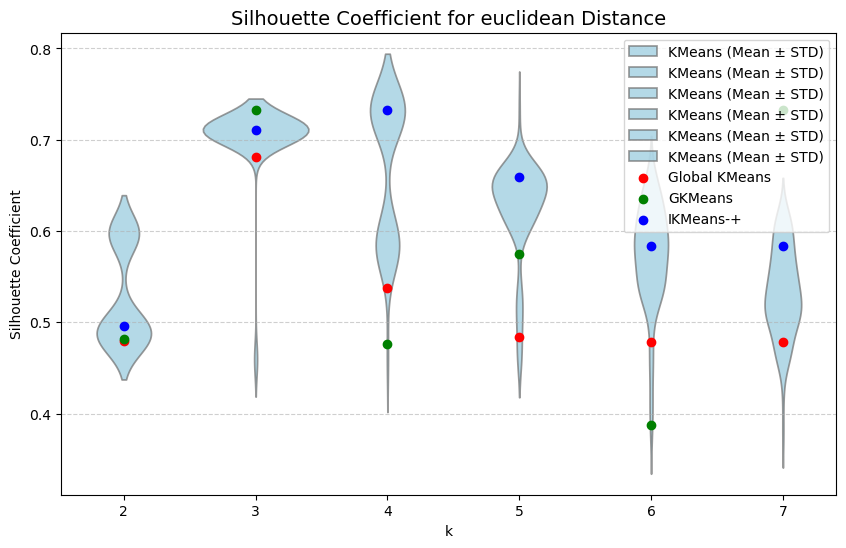

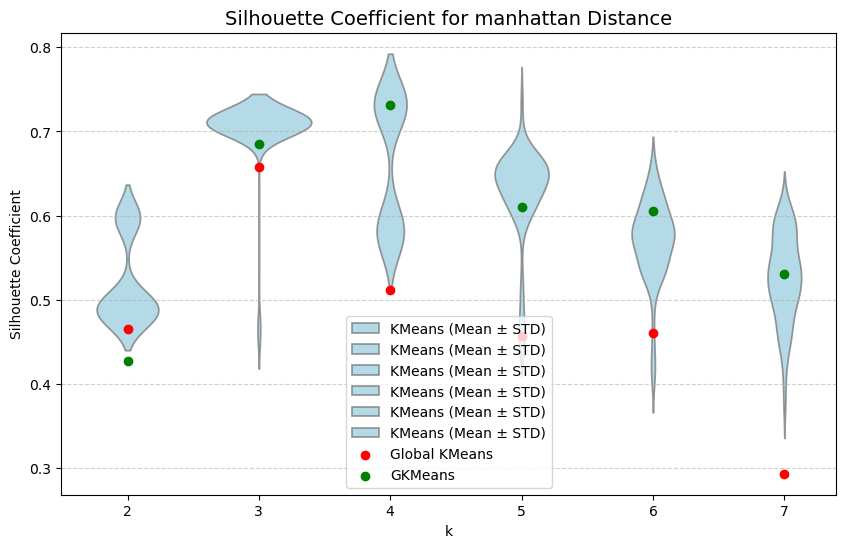

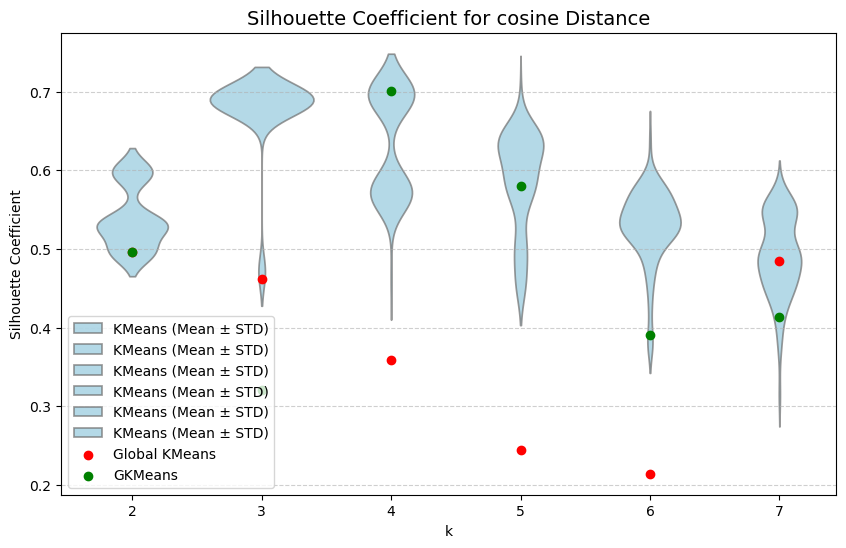

In [9]:
for dist in distances:

    results_dist = results_kmeans[results_kmeans['distance'] == dist]
    results_global_means_dist = results_global_means[results_global_means['distance'] == dist]
    results_ikmeans_dist = results_ikmeans[results_ikmeans['distance'] == dist]
    results_gmeans_dist = results_gmeans[results_gmeans['distance'] == dist]

    # Plot ARI as an example
    plt.figure(figsize=(10, 6))

    # Violin plot for `k` values
    sns.violinplot(data=results_dist, x="k", y="Silhouette Coefficient", inner=None, color="skyblue", alpha=0.7, label='KMeans (Mean ± STD)')

    plt.scatter(results_global_means_dist["k"]-2, results_global_means_dist["Silhouette Coefficient"], color="red", label="Global KMeans", zorder=3)

    plt.scatter(results_gmeans_dist["k"]-2, results_gmeans_dist["Silhouette Coefficient"], color="green", label="GKMeans", zorder=3)

    if dist == 'euclidean':
        plt.scatter(results_ikmeans_dist["k"]-2, results_ikmeans_dist["Silhouette Coefficient"], color="blue", label="IKMeans-+", zorder=3)

    # Add additional styling
    plt.title(f"Silhouette Coefficient for {dist} Distance", fontsize=14)
    plt.ylabel("Silhouette Coefficient")
    plt.xlabel("k")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()

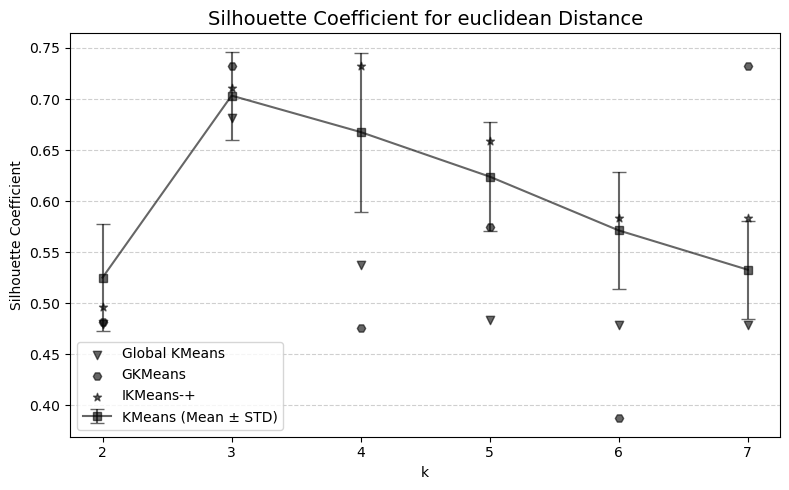

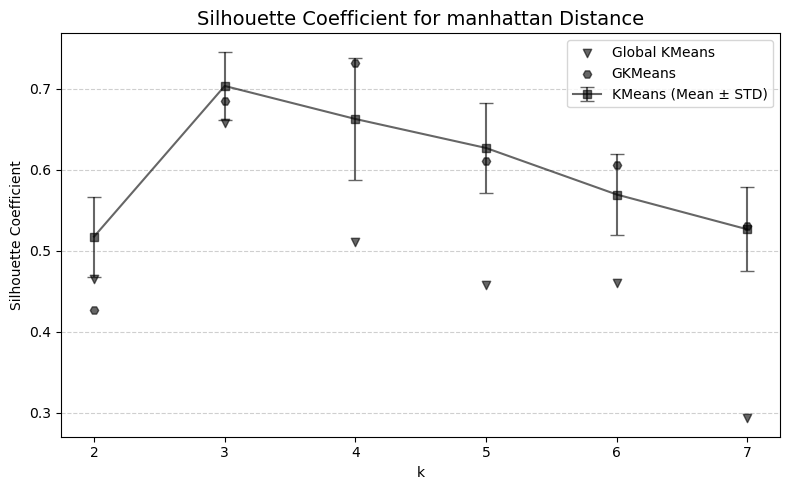

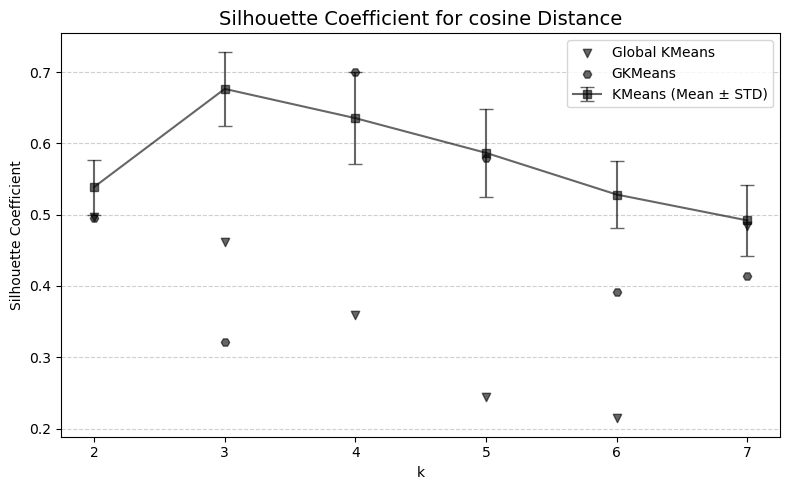

In [10]:
for dist in distances:
    results_dist = results_kmeans[results_kmeans['distance'] == dist]
    results_global_means_dist = results_global_means[results_global_means['distance'] == dist]
    results_ikmeans_dist = results_ikmeans[results_ikmeans['distance'] == dist]
    results_gmeans_dist = results_gmeans[results_gmeans['distance'] == dist]


    # Group by `k` to calculate statistics (mean and error range)
    grouped = results_dist.groupby("k")["Silhouette Coefficient"]
    means = grouped.mean()
    errors = grouped.std()  # Use standard deviation for error bars

    # Plot mean values with error bars
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        means.index, means, yerr=errors, fmt='s-', color='black', ecolor='black', capsize=5, label='KMeans (Mean ± STD)', alpha = 0.6)

    # Overlay the single-sample dataset
    plt.scatter(
        results_global_means_dist["k"], results_global_means_dist["Silhouette Coefficient"], marker = 'v', color = 'black', label="Global KMeans", zorder=3, alpha = 0.6)
    
    plt.scatter(results_gmeans_dist["k"], results_gmeans_dist["Silhouette Coefficient"], marker = 'H', color = 'black', label="GKMeans", zorder=3, alpha = 0.6)
    if dist == 'euclidean':
        plt.scatter(
            results_ikmeans_dist["k"], results_ikmeans_dist["Silhouette Coefficient"], marker = '*', color = 'black', label="IKMeans-+", zorder=3, alpha = 0.6)

    # Styling
    plt.title(f"Silhouette Coefficient for {dist} Distance", fontsize=14)
    plt.ylabel("Silhouette Coefficient")
    plt.xlabel("k")
    plt.xticks(sorted(results_dist["k"].unique()))  # Ensure k starts at 2
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


In [3]:
import os
from kmeans import run_kmeans
from global_kmeans import run_global_kmeans
from gmeans import run_gmeans
from utils import plot_clusters

Cluster 0 - Points shape: (472, 2)
Cluster 1 - Points shape: (472, 2)
Cluster 2 - Points shape: (472, 2)
Cluster 3 - Points shape: (472, 2)


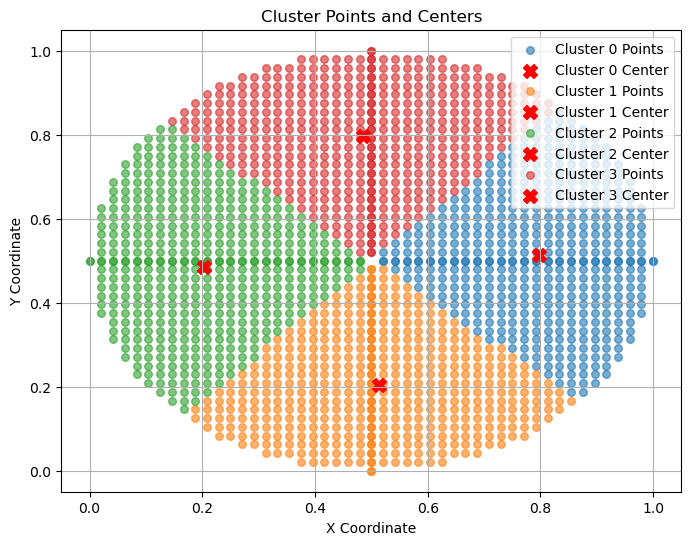

In [4]:
file = os.path.join('../datasets_processed',f'grid.csv')
df = pd.read_csv(file)
X = df.iloc[:,:-1]
k = 4
distance = 'euclidean'

clusters = run_kmeans(np.array(X), n_clusters=k, init=None, distance=distance)
plot_clusters(clusters)

In [5]:
clusters = run_global_kmeans(np.array(X), max_clusters=k, distance=distance)
plot_clusters(clusters)

KeyboardInterrupt: 

Cluster 0 - Points shape: (99, 2)
Cluster 1 - Points shape: (53, 2)
Cluster 2 - Points shape: (64, 2)
Cluster 3 - Points shape: (62, 2)
Cluster 4 - Points shape: (78, 2)
Cluster 5 - Points shape: (61, 2)
Cluster 6 - Points shape: (50, 2)
Cluster 7 - Points shape: (60, 2)
Cluster 8 - Points shape: (56, 2)
Cluster 9 - Points shape: (61, 2)
Cluster 10 - Points shape: (76, 2)
Cluster 11 - Points shape: (55, 2)
Cluster 12 - Points shape: (61, 2)
Cluster 13 - Points shape: (64, 2)
Cluster 14 - Points shape: (44, 2)
Cluster 15 - Points shape: (44, 2)
Cluster 16 - Points shape: (72, 2)
Cluster 17 - Points shape: (61, 2)
Cluster 18 - Points shape: (55, 2)
Cluster 19 - Points shape: (77, 2)
Cluster 20 - Points shape: (61, 2)
Cluster 21 - Points shape: (99, 2)
Cluster 22 - Points shape: (50, 2)
Cluster 23 - Points shape: (61, 2)
Cluster 24 - Points shape: (76, 2)
Cluster 25 - Points shape: (61, 2)
Cluster 26 - Points shape: (64, 2)
Cluster 27 - Points shape: (48, 2)
Cluster 28 - Points shape: (58

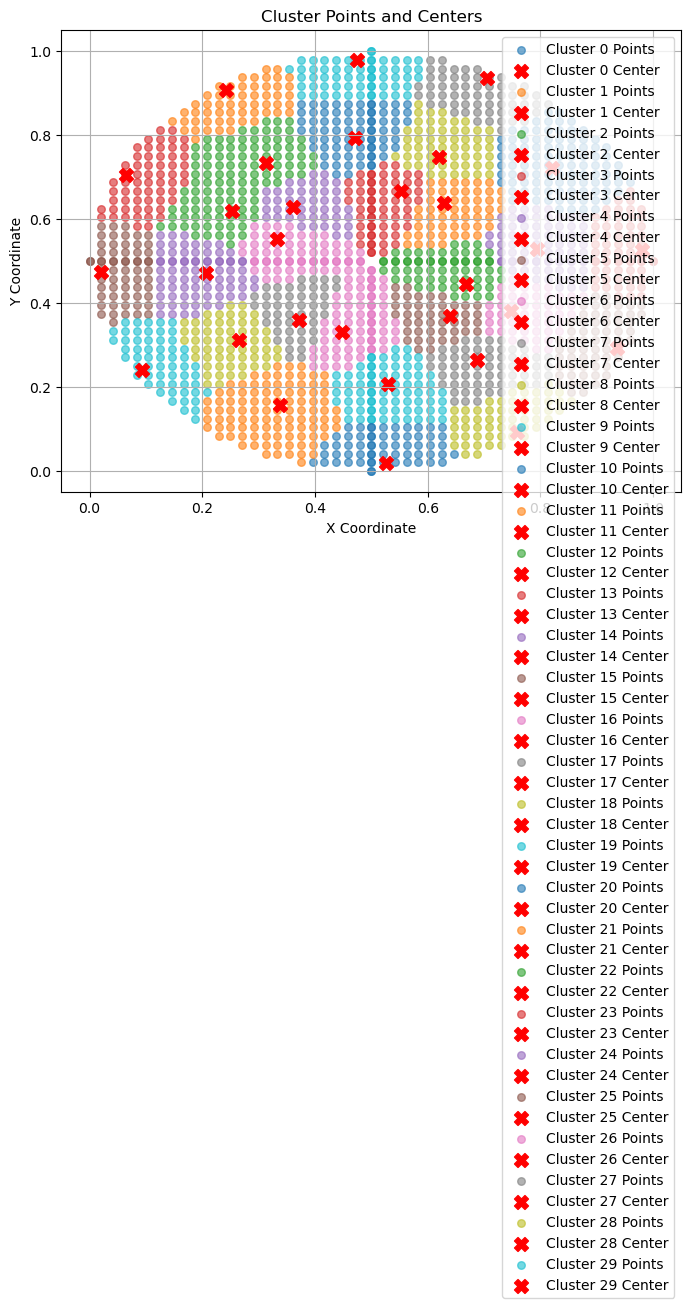

In [9]:
k = 20
clusters = run_gmeans(np.array(X), max_clusters=k, distance=distance)
plot_clusters(clusters)

In [15]:
file = os.path.join('../datasets_processed',f'vowel.csv')
df = pd.read_csv(file)

In [ ]:
# Load arff file
df_vowel, meta_train = loadarff(f'datasets/vowel.arff')

# Define datasets
df_vowel = pd.DataFrame(df_vowel)

y = df_vowel[['Class']]
df_vowel = df_vowel.drop(columns=['Class','Train_or_Test'])

df_vowel = one_hot_encoding(df_vowel)
df_vowel = binary_encoding(df_vowel)
df_vowel = min_max_scaler(df_vowel)

df_vowel = pd.concat([df_vowel, y])

df_vowel.to_csv(f'datasets_processed/vowel.csv', index=False)

,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Speaker_Number_b'Mike',Speaker_Number_b'Nick',Speaker_Number_b'Penny',Speaker_Number_b'Rich',Speaker_Number_b'Rose',Speaker_Number_b'Sarah',Speaker_Number_b'Sue',Speaker_Number_b'Tim',Speaker_Number_b'Wendy',Class
0,1.0,0.368150,0.266541,0.463757,0.842050,0.494947,0.778691,0.390816,0.546819,0.252909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,0.441218,0.278828,0.457631,0.732699,0.470440,0.875435,0.399320,0.541116,0.339493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1.0,0.723888,0.341525,0.232517,0.410988,0.358767,0.757193,0.325850,0.590936,0.275154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1.0,0.684778,0.485665,0.252425,0.639461,0.271349,0.599431,0.329932,0.458583,0.520876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1.0,0.611944,0.505986,0.418836,0.652668,0.124811,0.505849,0.656803,0.343037,0.646817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'hOd'
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'hod'
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'hUd'
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'hud'
